# 第7章 ベイジアンネットワークの実装

#### ・本章では、ベイジアンネットワークを活用した因果探索について解説、実装する .

## 7-1 ベイジアンネットワークとは

#### ・第3章で解説したグラフ表現(因果ダイアグラム)によるネットワーク図をベースとした、変数間の関係性を表す手法 .

#### そのため、有向(Directed)で非循環(Acyclic)なグラフであるDAG(Directed Acyclic Graph)の概念、及び因果推論においてどの変数を考慮すべきかを判断するd分離の概念は、ベイジアンネットワークでも共通である .

#### 非循環ではないネットワークを扱う手法もあるが、今回はDAGである因果ダイアグラムを対象とする .

## スケルトンとPDAG(Partially DAG)

#### ・スケルトンとは骨格構造のことであり、DAGにおいて、因果の方向を示す矢印がないグラフを示す .

#### スケルトンは、最終的なDAGにおいてどのノードとどのノードの間に繋がり(エッジ)が存在するのかの情報を与えてくれる .

#### ・PDAGはスケルトンとDAGの中間にあたる存在である .　一部の辺(エッジ)には因果の方向を示す矢印があるが、その他のエッジは無向となっているグラフを指す .

![alt text](pict1.png)

## ベイジアンネットワークのノード間の関係性

#### ・第6章のLiNGAMにおいては、構造方程式モデルを用意して、数式を利用して変数間の関係性を表現した .

#### ・ベイジアンネットワークでは構造方程式を用いず、因果関係のあるノード間の関係性を、"条件付き確率表(CPT : Conditional Probabilities Tables)と呼ばれる手法を利用する .

#### ・前出の図7.1.1における、変数$x_1$,$x_2$,$x_3$のCPTを例に示す(図7.1.2).　ここで変数$x_1$,$x_2$,$x_3$はすべて0か1となる2値変数とする .

![alt text](pict2.png)

#### ・図7.1.2では、変数$x_1$は確率60%で0、40%で1の値となる .　変数$x_2$は確率40%で0、60%で1の値となる .

#### 変数$x_3$は変数$x_1$、変数$x_2$から因果の矢印が伸びており、因果関係にあるため、変数$x_1$と変数$x_2$の値に応じて値が変わる .

#### 変数$x_3$がとる値の確率は$P(x_3=0|x_1,x_2)$で示される .　$x_3$のみが記載されているが、$x_3$の値は0か1なので、0のときの確率を1.0から引き算したものが$x_3 = 1$の確率となる .

#### そのため、$P(x_3=1|x_1,x_2)$の表は、図7.1.2では掲載を省略している .

#### ・例えば、$x_1=0$、$x_2=1$の場合、$x_3$は30%の確率で0、70%の確率で1になるということを示している .

#### ・ベイジアンネットワークにおいては変数間の関係を条件付き確率表CPTで表せるよう、変数を離散値として扱うことが一般的である .

#### 連続値として扱う手法も存在しますが、本書では変数を離散値に限る .

#### 仮に変数が連続値である場合には、ビンで区切ることで離散値に変換し、離散変数として扱う(連続変数の離散化については7.5節で扱う) .

## 7-2 ネットワークの当てはまりの良さを測る方法

#### ・ベイジアンネットワークにおいて、データに対するネットワークの当てはまりの良さを示す指標は複数存在する .

#### AIC(Akaike information criterion)
#### BIC(Bayesian information criterion)
#### MDL符号(minimum description length)
#### BDe(Bayesian Dirichlet equivalent)
#### BDeu(Bayesian Dirichlet equivalent uniform)
#### K2

#### ・本書ではBICを取り上げ、その概要を解説する .　BICは以下の式で計算される .

$$
BIC_m = -2\, l_m(\theta_m \mid X) + k_m (\log N)
$$

#### ・ここで下付き文字のmはモデルを表す .　すなわち、現在対象としているベイジアンネットワークのDAGです .　$X$は実測されたデータを示す .

#### $k_m$はモデルのパラメータ数を、$N$は実測されたデータ数を示す .　$l_m(\theta_m \mid X)$はデータ$X$のもとでのモデルの対数尤度である .

#### そして、$\theta_m $がベイジアンネットワークの構造、すなわち条件付き確率表CPTを示す .

![alt text](pict3.png)

#### ・図7.2.1の左側の図がモデルmを示す .　モデルのパラメータ数$k_m$はCPT(条件付き確率表)の行数となり6である .　

#### 図7.2.1ではCPTは8行ありますが、すべて2値変数なので、0の確率$P(0)$が分かれば、1の確率は"$1.0-P(0)$"である .

#### そのため、変数$x_1$と変数$x_2$の表はパラメータ数としては1行より、パラメータ数は6となる .

### プログラム実行前の設定

In [44]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

In [45]:
# 使用するパッケージ（ライブラリと関数）を定義
from numpy.random import *
import pandas as pd

#### ・次に、図7.2.1のベイジアンネットワークから、例えば以下の表7.2.1に示す10個のデータ$X$が観測されたとする .

![alt text](pict4.png)

#### 表7.2.1のデータ$X$を生成したコードは以下のようになる .

In [46]:
# データ数
num_data = 10

# x1：0か1の値をnum_data個生成、0の確率は0.6、1の確率は0.4
x1 = np.random.choice([0, 1], num_data, p=[0.6, 0.4])

# x2：0か1の値をnum_data個生成、0の確率は0.4、1の確率は0.6
x2 = np.random.choice([0, 1], num_data, p=[0.4, 0.6])

# 2変数で表にする
df = pd.DataFrame({'x1': x1,
                   'x2': x2,
                   })

# 表の先頭を表示
df.head()

,x1,x2
0,0,0
1,1,1
2,0,1
3,1,1
4,1,0


#### 上記で変数$x_1$と変数$x_2$を生成したのち、その値に応じて、変数$x_3$を生成する .

In [47]:
# 変数x3：0か1の値をnum_data個生成する
# (x1,x2)= (0,0)のとき、0の確率は0.2
# (x1,x2)= (1,0)のとき、0の確率は0.3
# (x1,x2)= (0,1)のとき、0の確率は0.4
# (x1,x2)= (1,1)のとき、0の確率は0.1

x3 = []
for i in range(num_data):
  if x1[i] == 0 and x2[i] == 0:
    x3_value = np.random.choice([0, 1], 1, p=[0.2, 0.8])
    x3.append(x3_value[0])  # x3はリストになっているので、0番目の要素を取り出して追加
  elif x1[i] == 0 and x2[i] == 1:
    x3_value = np.random.choice([0, 1], 1, p=[0.3, 0.7])
    x3.append(x3_value[0])
  elif x1[i] == 1 and x2[i] == 0:
    x3_value = np.random.choice([0, 1], 1, p=[0.4, 0.6])
    x3.append(x3_value[0])
  elif x1[i] == 1 and x2[i] == 1:
    x3_value = np.random.choice([0, 1], 1, p=[0.1, 0.9])
    x3.append(x3_value[0])

df["x3"] = x3

# データXの表示
df

,x1,x2,x3
0,0,0,1
1,1,1,1
2,0,1,0
3,1,1,1
4,1,0,1
5,0,1,1
6,0,1,1
7,1,0,1
8,1,1,1
9,1,1,1


#### ・ここで、注意点として、ベイジアンネットワークのモデルmはDAGの形を規定し、変数間の因果の有無、因果の方向性は指定するが、CPT(条件付き確率表)の具体的な確率値、例えば$P(x_1=0)$の値などは規定しない .

#### このCPTの具体的な確率値は得られたデータから計算し、そして計算した確率値のもとでデータの対数尤度を$l_m(\theta_m \mid X)$として求める .

#### ・対数尤度とは、統計モデルが観測データをどの程度適切に説明できるかを測る尺度のこと .

#### ・CPT(条件付き確率表)の具体的な確率値を$\hat{\theta}_{i,j,k}$と表す .　ここで$i$は変数$i$を示す .　$j$は変数$i$の条件のとあるパターンを示す .

#### 例えば今回の変数$x_3$であれば、4つのパターンが存在する .　最後に$k$は変数$i$の値を示す .

#### ・CPT(条件付き確率表)の具体的な確率値$\hat{\theta}_{i,j,k}$は

$$
\hat{\theta}_{i,j,k} = \frac{N_{ijk}}{N_{ij}}
$$

#### として計算される .　ここで、${N_{ijk}}$は変数$i$がとある条件パターン$j$で値$k$となったデータ数である .　${N_{ij}}$は変数$i$がとある条件パターン$j$であったデータ数である .

#### ただし、上記の計算式は、データが多項分布に従い、データの生成確率はすべてハイパーパラメータ0のディリクレ分布を仮定している .

#### ・変数$x_1$から順番に、正解のDAGの形、モデルmを与えて、表7.2.1のデータ$X$に対する$\hat{\theta}_{i,j,k}$を計算してみる .

#### ・変数$x_1$は条件付き確率ではないので、条件パターン$j$は存在しない .　よって$\hat{\theta}_{1,[],0}$は10個のデータから変数$x_1$が0の数を求めると4つであり、$N_{1[]0} = 4$である .



$$
\hat{\theta}_{1,[],0} = \frac{4}{10} = 0.4
$$

#### となる .　$\hat{\theta}_{1,[],0}$はすなわち、$P(x_1=0)$の推定値なので、$\hat{\theta}_{1,[],1}$は$1-\hat{\theta}_{1,[],0}$となり、0.6と求まる .

#### $P(x_1=0)=0.4$と$P(x_1=1)=0.6$が推定値で、真の答えは0.6と0.4だったので、正しい確率値が推定できていない .　これはデータ数が10個と少ないためである .

#### ・同様にして変数$x_2$の$\hat{\theta}_{2,[],0}$を求めると、

$$
\hat{\theta}_{2,[],0} = \frac{3}{10} = 0.3
$$

#### となる .　よって$\hat{\theta}_{2,[],1}$は0.7である .　真の答えの0.4と0.6からは若干ずれているが、まずまずの確率が推定されている .

#### ・最後に変数$x_3$のCPT(条件付き確率)を推定する .　変数$x_3$は変数$x_1$と変数$x_2$から因果を持ち、その条件付き確率で表されるため、条件パターン$j$は$[0,0]$,$[0,1]$,$[1,0]$,$[1,1]$の4つとなる .

#### $\hat{\theta}_{3,[0,0],0}$を求めると、$(x_1,x_2,x_3)=(0,0,0)$のデータが観測されておらず、$(x_1,x_2,x_3)=(0,0,1)$のデータは1つのため、

$$
\hat{\theta}_{3,[0,0],0} = \frac{0}{1} = 0.0
$$

#### となる .　$\hat{\theta}_{3,[0,0],1}$は1.0となる .　正解の0.2と0.8とは少しずれた推定結果である .

#### ・同様に他のパターンも計算する .　条件パターン$j=[0,1]$の場合は

$$
\hat{\theta}_{3,[0,1],0} = \frac{1}{3} = 0.33
$$

#### となり、$\hat{\theta}_{3,[0,1],1}$は0.67である .　$\hat{\theta}_{3,[1,0],0}$は 

$$
\hat{\theta}_{3,[1,0],0} = \frac{0}{2} = 0.0
$$

#### となり、$\hat{\theta}_{3,[1,0],1}$は1.0である .　$\hat{\theta}_{3,[1,1],0}$は

$$
\hat{\theta}_{3,[1,1],0} = \frac{0}{4} = 0.0
$$

#### となり、$\hat{\theta}_{3,[1,1],1}$は1.0となる .

#### ・以上で正解のDAGの構成mのもとでの、表7.2.1のデータ$X$に対する$\hat{\theta}_{i,j,k}$をすべて計算することができた .　最後に推定したCPT(条件付き確率表)を使用してデータ$X$の対数尤度$l_m(\theta_m \mid X)$を求める .　

#### ただし、$l_m(\theta_m \mid X)$そのものの値ではなく、$l_m(\theta_m \mid X)$に比例する値を計算する .　正確な$l_m(\theta_m \mid X)$の値は計算が大変なため、代わりに比例する値を計算する(複数のDAGの妥当性を比較するうえでは比例値を比較することで問題ない) .

#### ・$l_m(\theta_m \mid X)$に比例する値は、

$$
l_m(\theta_m \mid X) \propto \sum_i \sum_j \sum_k (N_{ijk}) \log \hat{\theta}_{i,j,k}
$$

#### で計算される .　表7.2.1の場合は、

$$
l_m(\theta_m \mid X) \propto 4 \times \log 0.4 + 6 \times \log 0.6 + 3 \times \log 0.3 + 7 \times \log 0.7 + 1 \times \log 1.0 + 1 \times \log 0.33 \\
+ 2 \times \log 0.67 + 2 \times \log 1.0 + 4 \times \log 1.0 = -14.7
$$

#### となる .

#### ・最後にBICの計算に戻ると、

$$
BIC_m = -2\, l_m(\theta_m \mid X) + k_m (\log N)
$$

#### であったので、

$$
BIC_m = -2 \times -14.7 + 6 \times (\log 10) = 43.3
$$

#### となります .

#### ・以上により、正解のDAG、すなわちとあるベイジアンネットワークmに対する、計測されたデータのBIC値を計算することができた .

#### 実際には正解のDAGの形mは不明なので、複数のDAGのBIC値を比較することになる .

#### ・ここまで手計算でBICを求めたが、実装時にはベイジアンネットワークのライブラリを活用する .　ベイジアンネットワークを扱えるPythonのライブラリはいくつか種類が存在するが、本書ではpgmpy(Python library for Probabilistic Graphical Models)を利用する .

In [48]:
!pip install pgmpy==0.1.9

#### 正解のDAGを与える .

In [49]:
# 正解のDAGを与える
from pgmpy.models import BayesianNetwork
model = BayesianNetwork([('x1', 'x3'), ('x2', 'x3')])  # x1 -> x3 <- x2

ModuleNotFoundError: No module named 'pgmpy.extern.six.moves'

#### 次に、CPT(条件付き確率表)を計算するベースとなる各パターンでのデータ数を描画、確認する .

In [ ]:
# 各データパターンの個数を表示する
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, df)
print("\n", pe.state_counts('x1'))
print("\n", pe.state_counts('x2'))
print("\n", pe.state_counts('x3'))

![alt text](picta1.png)

#### 次に、CPT(条件付き確率表)を推定する .

In [ ]:
# CPT（条件付き確率表）を推定する
from pgmpy.estimators import BayesianEstimator

estimator = BayesianEstimator(model, df)

cpd_x1 = estimator.estimate_cpd(
    'x1', prior_type="dirichlet", pseudo_counts=[[0], [0]])
cpd_x2 = estimator.estimate_cpd(
    'x2', prior_type="dirichlet", pseudo_counts=[[0], [0]])
cpd_x3 = estimator.estimate_cpd('x3', prior_type="dirichlet", pseudo_counts=[
                                [0, 0, 0, 0], [0, 0, 0, 0]])
# 注意：pseudo_countsはハイパーパラメータ0のディリクレ分布の設定を与えています。

print(cpd_x1)
print(cpd_x2)
print(cpd_x3)

![alt text](picta2.png)

#### 手計算で求めた結果と同じCPTが得られている .　最後にBICを計算する .

In [ ]:
# BICを求める
from pgmpy.estimators import BicScore
bic = BicScore(df)
print(bic.score(model))
# -21.65605747450808

#### ・先ほど手計算したBICの値43.3と、pgmpyの出力値が異なっており、43.3ではなく-21.7になっている .　これはpgmpyのBIC計算が、手計算した式

$$
BIC_m = -2\, l_m(\theta_m \mid X) + k_m (\log N)
$$

#### ではなく、

$$
BIC_m = l_m(\theta_m \mid X) - 0.5 \times k_m (\log N) = -14.7 - 0.5 \times 6 \times (\log 10)
$$

#### として計算されているためである .　手計算した式に-0.5が掛け算されている .　BICの計算にもいくつか種類があり、手計算したものは基本的に良く使用されるもの、pgmpyの計算式も使用される .

#### ・最後に正解ではないDAGでのBICを計算してみる .　正解のDAGは変数$x_3$が変数$x_1$と変数$x_2$から因果を持つ構造であったが、変数$x_2$から変数$x_1$,$x_3$に因果関係があるとする .

In [ ]:
# 正解ではないDAGを与える
from pgmpy.models import BayesianModel
model = BayesianModel([('x2', 'x1'), ('x2', 'x3')])  # x1 <- x2 -> x3
bic = BicScore(df)
print(bic.score(model))
# -21.425819218840655

#### ・先ほどの正解のDAGでのBICが-21.6であったのに対して、-21.4と大きな値になった .　ここで使用しているpgmpyのBICの定義では、より大きな値になるほど(負の方向に小さくなるほど)良いモデルであるため、今回はたまたま正解ではないDAGの方が値が良くなっている .

#### 原因としてデータ数が少ないことが主であると考えられる .

## 7-3 変数間の独立性の検定

#### ・本節では観測したデータから、2つの変数の間に因果関係が存在しているのか、それとも独立な変数なのかを判定する手法について解説する .

#### ただし、独立性を確かめる手法で、変数間の因果関係の有無は分かるが、因果の方向性は分からない .　また2変数が独立でなかった場合に、直接的な因果関係にあるのか、別の変数を介した間接的な因果関係にあるのかは分からない .

#### ・しかしこの独立性の検定を繰り返して利用することで、どの変数間に因果関係があるのかを明らかにし、DAGを推定するベースとなるスケルトンを求めることができる .

#### ・はじめに独立性の検定の仕組みを解説し、次に疑似データに対して独立性検定の実装、実施を行う .

## 独立性の検定

#### ・変数間の条件付きの独立性の検定について解説する .

#### ・ここで"条件"を$C$と表すことにする .　例えば、変数$x_3=1$などである .　条件$C$が存在しないケースもある .

#### ・次に独立性を検定したい変数を$x_1$,$x_2$とここでは仮定する .

#### すると、2変数間の条件付き独立関数は$CI(x_i,x_j|C)$と表現され、上記の例の場合、$CI(x_1,x_2|x_3=1)$と記載される .　ここで、CIはConditional independence(条件付き独立)を意味する .

#### ・この$CI(x_1,x_2|x_3=1)$の検定として、"独立性のカイ二乗検定"や"G^2テスト"(G-square testもしくはG検定と呼ぶ)が使用される .　本書では独立性のカイ二乗検定について解説する .

## 独立性のカイ二乗検定

#### ・統計検定では帰無仮説と呼ばれる仮説を検討する .　独立性の検定の場合は、帰無仮説は「変数$x_1$と変数$x_2$は独立である」である .　帰無仮説は$H_0$で表記される .

#### ・帰無仮説が棄却されると、「変数$x_1$と変数$x_2$は独立ではない」と判定できる .　帰無仮説が棄却できない場合は、「変数$x_1$と変数$x_2$は独立」と判定できるわけではなく、「変数$x_1$と変数$x_2$は独立なのか独立ではないのかは判断できない」という判定になる .

#### ・ここで、カイ二乗統計量と呼ばれる指標をデータから計算し、カイ二乗統計量の値が「変数$x_1$と変数$x_2$は独立である」と仮定した場合に比べて、著しく大きければ前提である独立という仮定がおかしかったということになる .　すると、最初に立てた帰無仮説が棄却できる .

#### ・表7.3.1のようなデータが得られていたとする .　表7.3.1は独立性の検定をしたいデータ$X$の各条件での頻度(各個数)となっている .　今回は変数$x_1$と変数$x_2$は独立ではなく、因果関係にあるとする .

![alt text](pict5.png)

#### 以下の実装により、表7.3.1のデータを生成している .

In [50]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

In [51]:
# 使用するパッケージ（ライブラリと関数）を定義
from numpy.random import *
import pandas as pd

In [52]:
# データ数
num_data = 100

# x1：0か1の値をnum_data個生成、0の確率は0.6、1の確率は0.4
x1 = np.random.choice([0, 1], num_data, p=[0.6, 0.4])

# x2：0か1の値をnum_data個生成、0の確率は0.4、1の確率は0.6
x2 = np.random.choice([0, 1], num_data, p=[0.4, 0.6])

# x2はx1と因果関係にあるとする
x2 = x2*x1

# 2変数で表にする
df = pd.DataFrame({'x1': x1,
                   'x2': x2,
                   })

# 表の先頭を表示
df.head()

,x1,x2
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1


In [53]:
# 各カウント
print(((df["x1"] == 0) & (df["x2"] == 0)).sum())
print(((df["x1"] == 1) & (df["x2"] == 0)).sum())
print(((df["x1"] == 0) & (df["x2"] == 1)).sum())
print(((df["x1"] == 1) & (df["x2"] == 1)).sum())

58
9
0
33


#### ・表7.3.1の変数$x_1$と変数$x_2$の分布表(度数分布表)からカイ二乗統計量を計算する .　カイ二乗統計量は、

$$
\chi^2 = \sum_{i=1}^r \sum_{j=1}^c \frac{(n_{ij} - E_{ij})^2}{E_{ij}}
$$

#### で計算される .　ここで、$r$は度数分布表の行数、$c$は列数である .　$n_{ij}$は$i$行目$j$列目の度数を示す .　$E_{ij}$は$i$行目$j$列目の推定期待度数である .

#### ・推定期待度数とは、変数$x_1$と変数$x_2$が独立であったとすればどの程度の値になるかを示し、

$$
E_{ij} = \frac{n_i \times n_j}{N}
$$

#### で計算される .　ここで$n_i$は$i$行目のデータの総数、$n_j$は$j$列目のデータの総数、$N$は全データ数である .

#### ・表7.3.2に推定期待度数の表を示す .　これは例えば$E_{11}$の推定期待度数は、

$$
E_{11} = \frac{58\times67}{100}
$$

#### のように計算される .

![alt text](pict6.png)

#### 表7.3.1の観測データの度数と、表7.3.2の推定期待度数より、カイ二乗統計量は

$$
\chi^2 = 
\frac{(58 - 38.9)^2}{38.9}
+ \frac{(0 - 19.1)^2}{19.1}
+ \frac{(9 - 28.1)^2}{28.1}
+ \frac{(33 - 13.9)^2}{13.9}
= 68.0
$$

#### となる .

#### ・次にこのカイ二乗統計量と、変数$x_1$と変数$x_2$が独立である場合の値と比較する .

#### ・カイ二乗統計量は度数分布表の行数、列数で値が大きく変わるので、その点を調整してあげる必要がある .　行数や列数が多いほどカイ二乗統計量の値も大きくなる .

#### その調整のための考慮する量を自由度と呼ぶ .

#### ・自由度は度数分布表の行数$r$、列数$c$を利用して、$(r-1)(c-1)$と計算する .　1を引くのは確率や度数は全体のデータ数が分かっていれば、最後の行や列の値は、その他の行と列から計算(1.0-その他の総和)で計算できるからである .

#### ・最後にこの自由度での変数$x_1$と変数$x_2$は独立である場合のカイ二乗統計量と比較して、今回のデータから得られたカイ二乗統計量が、どれくらい滅多にないことなのかを求める .

#### そのためには、カイ二乗分布表と比べることになる .

![alt text](pict7.png)

#### ・カイ二乗分布表から、自由度1の変数$x_1$と変数$x_2$が独立である場合のカイ二乗統計量は50%の確率で0.455以下と分かる .　同様に90%の確率で2.71以下、95%の確率で3.84以下と分かる .

#### ・どれくらい珍しいデータであれば、それは独立でない変数から生まれたと判定するのかは、有意確率$p$をあらかじめ決めておくことになる .

#### 一般的には$p=0.05$で、5%以下でしか発生しないようなデータが得られた場合は、初めに立てた帰無仮説、すなわち今回の場合は「変数$x_1$と変数$x_2$は独立である」に無理があったと判定して、2つの変数は関連している、因果の関係にあると判断する .

#### ・今回のデータから得られたカイ二乗統計量は68.0であり、自由度1のカイ二乗分布表は95%の確率で3.84以下です .

#### 言い換えると、3.84以上の値を取るのは5%以下の珍しいケースであるということである .

#### 今回$p=0.05$を棄却の基準とした場合、5%以下でしか発生しない状況になっている .　そのため、「変数$x_1$と変数$x_2$は独立である」という考えに無理があった、すなわち帰無仮説を棄却し、「変数$x_1$と変数$x_2$は独立ではない、関連しており、因果関係にある」と判定する .

## 条件付きの独立性のカイ二乗検定

#### ・条件付きの状況においても独立性のカイ二乗検定は同じ手順となる .

#### 独立性を検定したい2変数について、その条件のもとでの度数分布表を作成し、推定期待度数を求め、自由度を計算し、その自由度での変数$x_1$と変数$x_2$は独立である場合のカイ二乗統計量と比較して、帰無仮説が棄却できるかを判定する .

## pgmpyでの実装

#### ・2変数が独立の場合に、7.2節で使用したpgmpyで独立性を検定する .

In [54]:
# データ数
num_data = 100

# x1：0か1の値をnum_data個生成、0の確率は0.6、1の確率は0.4
x1 = np.random.choice([0, 1], num_data, p=[0.6, 0.4])

# x2：0か1の値をnum_data個生成、0の確率は0.4、1の確率は0.6
x2 = np.random.choice([0, 1], num_data, p=[0.4, 0.6])

# 2変数で表にする
df2 = pd.DataFrame({'x1': x1,
                   'x2': x2,
                   })

# 各カウント
print(((df2["x1"] == 0) & (df2["x2"] == 0)).sum())
print(((df2["x1"] == 1) & (df2["x2"] == 0)).sum())
print(((df2["x1"] == 0) & (df2["x2"] == 1)).sum())
print(((df2["x1"] == 1) & (df2["x2"] == 1)).sum())

20
15
35
30


#### ・独立性の検定を実施する .　なお本節の最初で使用したデータ(因果関係があり、独立でないバージョン)にも、検定を実施する .

In [ ]:
from pgmpy.estimators import ConstraintBasedEstimator

est = ConstraintBasedEstimator(df2)
print(est.test_conditional_independence(
    'x1', 'x2', method="chi_square", tol=0.05))  # 独立(True)

# 最初の例の場合
est = ConstraintBasedEstimator(df)
print(est.test_conditional_independence(
    'x1', 'x2', method="chi_square", tol=0.05))   # 独立でない(False)

#### ・出力はTrue,Falseとなり、今回新たに独立なデータを作成したケースでは独立と判定され、本節の最初から使用してきた独立でないデータでは、Falseとして独立とは言えないと正しく判定された .

## 7-4　3タイプのベイジアンネットワークの探索手法

#### ・本節では観測したデータから、ベイジアンネットワークのDAGを推定する手法について解説する .

#### ・3タイプのネットワーク探索手法とは、以下の通りである .

#### ①スコアリングによる構造学習(Score-based Structure Learning)
#### ②条件付き独立性検定による構造学習(Constraint-based Structure Learning)
#### ③ベイジアンスコアと条件付き独立性検定のハイブリッド型構造学習(Hybrid Structure Learning)

#### ・①スコアリングによる構造学習とは、7.2節で解説した、観測データに対するネットワークの当てはまりの良さを示すAIC,BIC,MDL符号,BDe,BDeu,K2などのベイジアンスコアのいずれかを使用し、様々なDAGに対してスコアを求め、最も指標値の良いDAGを選ぶ手法のこと .

#### スコアリングによる構造学習は、手法がシンプルという利点がある一方で、扱うデータの変数が多くなればなるほどDAGのパターンが爆発的に増加するため、それら全てのベイジアンスコアを計算することが現実的には難しくなるという欠点がある .

#### そのため全パターンのDAGを比較するのではなく、厳密性を犠牲にして計算量を減らす手法なども提案されている .
#### (具体的には動的計画法や幅優先分岐限定方、A*ヒューリスティック探索などが存在する .)

#### ・②条件付き独立性検定による構造学習とは、7.3節で解説した変数間の独立性の検定を各条件付きパターンで繰り返し、スケルトン構造を同定する .

#### その後、スケルトン構造をルールベースで部分的に方向付けをしていき、PDAG(Partially DAG)を作る .　この方向付けのルールは"オリエンテーションルール"と呼ばれる .

#### オリエンテーションルールによる方向付けとPDAGの構築を繰り返すことで、DAGを推定する .

#### 条件付き独立性検定による構造学習の代表的なアルゴリズムとしては"PCアルゴリズム"が使用される .　7.5節ではこのPCアルゴリズムを実装する .

#### ・③ハイブリッド型構造学習とは、スコアリングによる構造学習と条件付き独立性検定による構造学習とを組み合わせた手法のこと .　代表的な手法としては"MMHCアルゴリズム(Max-Min Hill Climbing algorithn)"が使用される .

#### これはPCアルゴリズムなどの条件付き独立性検定による構造学習でも、計算量が多いので、もっと効率よく因果探索するための手法である .

#### ・例えばMMHCでは、はじめにターゲットとなるノード変数を1つ設定し、これは因果探索時に最も着目する変数を選択する .　そしてそのターゲット変数(ノード)を中心とした隣接するベイジアンネットワークを求める .

#### その後、ターゲットノードを中心に構築されたベイジアンネットワークに現れた変数(ノード)を、次のターゲットに置き換えて、それらに隣接するベイジアンネットワークを構築する .　これを繰り返すことで徐々に構築するネットワークを拡大させていく .

#### ・ターゲットノードを中心に隣接するベイジアンネットワークを求める手法として、Max-Minヒューリスティックを使用する .

#### ターゲットノード変数と、各変数との条件付き独立性検定を実施し、最も関連度が高い(Max)ノードを1つ追加する .　そして、基準より独立性が高い(すなわち関連度が低い)ノードは周辺ネットワークの候補から除外する .

#### ・ターゲットノードと上記で追加したMaxノードの2変数を条件に、条件付き独立性検定を実施し、そこで最も関連度が高い(Maxな)ノードを1つ加える .　そして、基準より独立性が高い(すなわち関連度が低い)ノードは周辺ネットワークの候補から除外する .　

#### この操作を繰り返すことで、ターゲットノード周辺のベイジアンネットワークのスケルトンを求め、その後、そのスケルトンに対してルールベースで方向付けを実施したり、①スコアリングによる構造学習を実施したりして、DAGを求める、という手順になる .

## 7-5 PCアルゴリズムによるベイジアンネットワーク探索の実装

#### ・②条件付き独立性検定による構造学習である、PCアルゴリズムによる因果探索を実装する .

#### ・使用する疑似データについて、その生成部分を実装、解説する .　第5章でも使用した「上司向け:部下とのキャリア面談のポイント研修」を少し複雑にした疑似データを生成して使用する .

#### ・本節で生成するデータは連続値をとるので、離散変数を扱うベイジアンネットワーク手法でも取り扱えるように、連続値をビンで区切り、離散変数へ変換してDAGを推定する .

#### 疑似データ「上司向け:部下とのキャリア面談のポイント研修」の生成

#### ・データの構造は以下の図7.5.1の通りである .

![alt text](pict8.png)

#### ・上司の部下育成の熱心さ$x$
#### ・上司がキャリア面談のポイント研修を受講したかどうか$Z$
#### ・部下の面談の満足度$Y$

#### ・1つ目の追加変数は、「部下当人のチームメンバーへの満足度$Y2$」である .　これは1から5の5段階で部下当人が入力すると仮定する .

#### ・2つ目の追加変数は、「部下当人の仕事への満足度$Y3$」である .　変数$Y3$も部下当人が入力すると仮定する .　ただし仕事への満足度は$Y$と$Y2$から因果を持っており、この2変数から計算されているという前提をおいて、プログラムの実装では計算式で求める .

#### 注意点として、$Y$や$Y2$以外の$Y3$への他の要因は、因果ダイアグラムでは全てノイズとして、「部下当人の仕事への満足度$Y3$」に加わることを前提とする .　また、そのノイズは図7.5.1のその他の要因に加わるノイズとは独立であるという前提がある .

#### ・3つ目の追加変数は、「部下当人の仕事のパフォーマンス$Y4$」である .　これは、「部下当人の仕事への満足度$Y3$」と、他の要因を考慮したノイズ成分から計算されるとする .

### プログラム実行前の設定など

In [55]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)

In [56]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd

### データの作成

In [57]:
# データ数
num_data = 2000

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y

#### ・本章で追加した変数$Y2$,$Y3$,$Y4$を生成する .

In [58]:
# 本章からの追加データを生成

# Y2：部下当人のチームメンバへの満足度 1から5の5段階
Y2 = np.random.choice([1.0, 2.0, 3.0, 4.0, 5.0],
                      num_data, p=[0.1, 0.2, 0.3, 0.2, 0.2])

# Y3：部下当人の仕事への満足度
e_y3 = randn(num_data)
Y3 = 4*Y + Y2 + e_y3

# Y4：部下当人の仕事のパフォーマンス
e_y4 = randn(num_data)
Y4 = 3*Y3 + 5 + 2*e_y4 

### データの可視化

In [59]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   'Y2': Y2,
                   'Y3': Y3,
                   'Y4': Y4,
                   })

# データの先頭を表示
df.head()  

,x,Z,t,Y,Y2,Y3,Y4
0,-0.616961,1.0,0.5,2.286924,2.0,11.019469,37.187280
1,0.244218,1.0,0.7,2.864636,3.0,13.608595,45.742923
2,-0.124545,0.0,0.5,2.198515,3.0,12.767678,45.076731
3,0.570717,1.0,1.0,3.230572,3.0,15.543099,53.400946
4,0.559952,0.0,1.0,2.459267,5.0,14.878006,48.211738


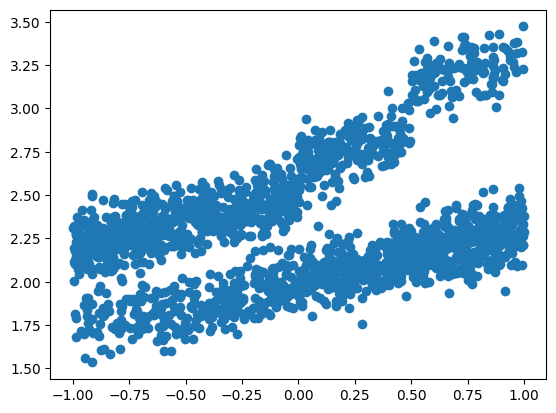

In [60]:
# グラフで確認
plt.scatter(x, Y)

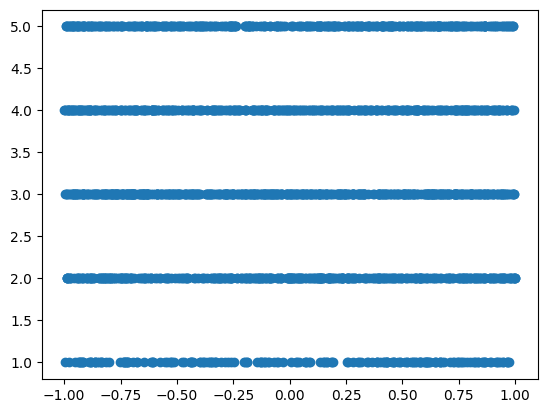

In [61]:
# グラフで確認
plt.scatter(x, Y2)

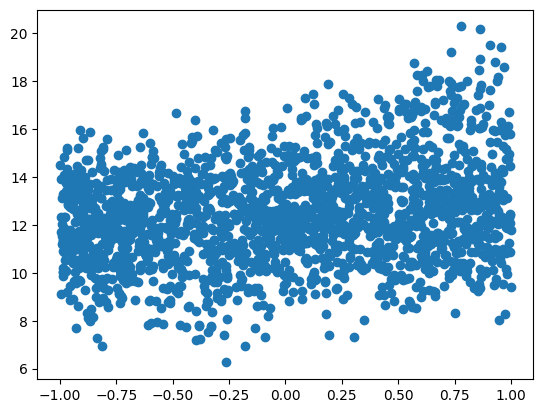

In [62]:
# グラフで確認
plt.scatter(x, Y3)

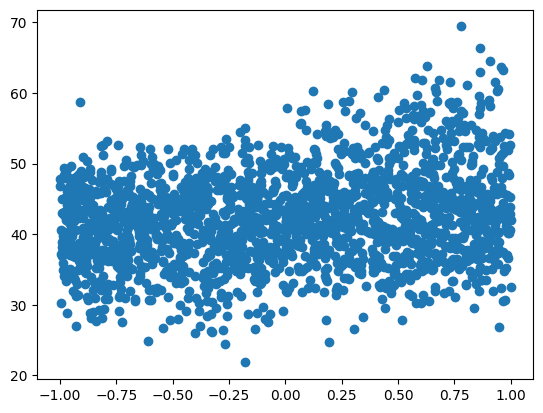

In [63]:
# グラフで確認
plt.scatter(x, Y4)

## データの離散化

#### ・データの離散化にはpandasのcut関数を使用する .　pandasにはcutとqcutの2つの関数があり、cutは離散化の基準となる閾値を等分する .　一方でqcutの場合には離散化されたデータ数がビンごとに同数になるように閾値が決定される .

#### ・区切るビンの数が多い方が、より正確なベイジアンネットワーク、DAGを推定できる .

### データをビンで区切る

In [64]:
# ビン区切りの例
# cutを使用すると閾値で区切れる
# qcutを使用すると同じデータ数になるように区切る
s_qcut, bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

print(s_qcut)
print("=======")
print(bins)

0       2
1       4
2       2
3       5
4       3
       ..
1995    2
1996    2
1997    2
1998    2
1999    2
Name: Y, Length: 2000, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
[1.532537   1.92223596 2.30999611 2.69775627 3.08551643 3.47327659]


#### ・実装コードにおいて、引数のretbinsをTrueに設定することで、区切りの閾値を獲得できる .　上記実装では変数binsに格納され、binsの出力を見ると、離散化された値が1で元の値は1.53〜1.92の間にあったことがわかる .

#### ・今回のデータを離散値へと変換する .　今回はcutを使用し、1から5の5段階で連続値を離散化する .

In [65]:
# データを区切る
df_bin = df.copy()  # コピーしてビン区切りデータを入れる変数を作成
del df_bin["t"]  # 変数tは観測できないので削除

# x：部下育成への熱心さ
df_bin["x"], x_bins = pd.cut(df["x"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Z：上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
# ※qcutではなく、cutで値に応じて分割
df_bin["Z"], z_bins = pd.cut(df["Z"], 2, labels=[0, 1], retbins=True)

# Y：部下の面談の満足度
df_bin["Y"], y_bins = pd.cut(df["Y"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y2：部下当人のチームメンバへの満足度 1から5の5段階
# # ※qcutではなく、cutで値に応じて分割
df_bin["Y2"], y2_bins = pd.cut(
    df["Y2"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y3：部下当人の仕事への満足度
df_bin["Y3"], y3_bins = pd.cut(
    df["Y3"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# Y4：部下当人の仕事のパフォーマンス
df_bin["Y4"], y4_bins = pd.cut(
    df["Y4"], 5, labels=[1, 2, 3, 4, 5], retbins=True)

# 確認
df_bin.head()

,x,Z,Y,Y2,Y3,Y4
0,1,1,2,2,2,2
1,4,1,4,3,3,3
2,3,0,2,3,3,3
3,4,1,5,3,4,4
4,4,0,3,5,4,3


## PCアルゴリズムによる因果探索　その1　0次の独立性

#### ・0次の独立性とは、2つの変数間にとある変数0個を条件付きにした際の独立性の検定である .　つまり、条件なし時の変数間での独立性の検定となる .　今回は独立性のカイ二乗検定を利用する .

In [66]:
!pip install pgmpy==0.1.9

#### ・今回変数は、$x$,$Z$,$Y$,$Y2$,$Y3$,$Y4$の6個なので、6×5÷2=15で、15ペアの検定を実施する .　もっと効率の良く行数の少ない実装方法もあるが、分かりやすさを重視し、愚直に実装する .

In [ ]:
from pgmpy.estimators import ConstraintBasedEstimator

est = ConstraintBasedEstimator(df_bin)

# 0次の独立性の検定
print(est.test_conditional_independence(
    'x', 'Z', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Z', 'Y', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y', 'Y2', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y2', 'Y3', method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', method="chi_square", tol=0.05))
print("=====")
print(est.test_conditional_independence(
    'Y3', 'Y4', method="chi_square", tol=0.05))
print("=====")

![alt text](picta3.png)

#### ・「0次の独立性の検定」を実施した結果、独立であった変数ペア、独立とは判断できない(今回は関連あるとする)変数ペアが明らかになった .　結果を図7.5.2にまとめる .

![alt text](pict9.png)

#### ・図7.5.2の左側の表から、変数$x$と変数$Y2$は独立と判定された .　そのため、図7.5.2の右側のベイジアンネットワークにおいて、変数$x$と変数$Y2$を結ぶエッジ(辺)は削除される .

#### 一方で、変数$x$とその他の変数の独立性は確認できなかったため、変数$x$とその他の変数の間のエッジが描かれている .

#### 変数$x$だけでなく、他の変数も同様に独立性の検定結果からエッジを描く .

## PCアルゴリズムによる因果探索　その2　1次の独立性

#### ・1次の独立性とは、2つの変数間にとある変数1個を条件付きにした際の独立性の検定のことである .　条件付きにする変数は対象とする変数と関連があったものから選ぶ .

#### 例えば、変数$x$であれば0次の検定で4つの変数と関連しているので、確認する独立性は、$CI(x,Z|Y)$,$CI(x,Z|Y3)$,$CI(x,Z|Y4)$,$CI(x,Y|Z)$,$CI(x,Y|Y3)$,$CI(x,Y|Y4)$,$CI(x,Y3|Z)$,$CI(x,Y3|Y)$,$CI(x,Y3|Y4)$,$CI(x,Y4|Z)$,$CI(x,Y4|Y)$,$CI(x,Y4|Y3)$の12(4×3)個を確認することになる .

In [ ]:
# 1次の独立性の検定 変数x
print(est.test_conditional_independence(
    'x', 'Z', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'x', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'x', 'Y4', ['Y3'], method="chi_square", tol=0.05))

![alt text](picta4.png)

#### ・実装した結果、True(すなわち、独立)と判定されたのは、$CI(x,Y3|Y)$,$CI(x,Y3|Y4)$,$CI(x,Y4|Y)$,$CI(x,Y4|Y3)$の4つである .

#### 例えば、$CI(x,Y3|Y)$が独立と判定されたので、変数$x$と変数$Y$が関連していれば(エッジでつながれていれば)、変数$x$と変数$Y3$は独立となる .　よって、変数$x$と変数$Y$をつなぐエッジを残し、変数$x$と変数$Y3$をつなぐエッジは消去される .

#### 同様に、変数$x$と変数$Y4$をつなぐエッジも消去される .　変数$x$に関する「1次の独立性検定」の結果を図7.5.3に示す .

![alt text](pict10.png)

#### ・続いて変数$Z$について「1次の独立性検定」を実施する .　変数$Z$は、変数$x$,$Y$,$Y3$,$Y4$と4つの変数とつながっているので、4×3の12ペアを確認する .

In [ ]:
# 1次の独立性の検定 変数Z
print(est.test_conditional_independence(
    'Z', 'x', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Z', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Z', 'Y4', ['Y3'], method="chi_square", tol=0.05))

![alt text](picta5.png)

#### ・独立性検定の結果、Trueと判定されたのは、$CI(Z,Y3|Y)$,$CI(Z,Y4|Y)$,$CI(Z,Y4|Y3)$の3つである .　よって、変数$Z$と$Y3$および$Y4$をつなぐエッジを消去する .

![alt text](pict11.png)

#### ・次に同様に変数$Y$について「1次の独立性検定」を実施する .　いま変数$Y$は変数$x$,$Z$,$Y3$,$Y4$とつながっているので、4×3の12回検定する .

In [ ]:
# 1次の独立性の検定 変数Y
print(est.test_conditional_independence(
    'Y', 'x', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'x', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Z', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y3', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y', 'Y4', ['x'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Z'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y4', ['Y3'], method="chi_square", tol=0.05))

![alt text](picta6.png)

#### ・変数$Y$について検定した結果、$CI(Y,Y4|Y3)$が独立と判定された .　すなわち、変数$Y$と変数$Y3$の関連があれば、変数$Y$と変数$Y4$は独立となるため、変数$Y$と変数$Y4$をつなぐエッジを削除する .

![alt text](pict12.png)

#### ・次に変数$Y2$について「1次の独立性検定」を実施する .　変数$Y2$は変数$Y4$,$Y3$とつながっているので、2×1の2回検定する .

In [ ]:
# 1次の独立性の検定 変数Y2
print(est.test_conditional_independence(
    'Y2', 'Y3', ['Y4'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))

![alt text](picta7.png)

#### ・変数$Y2$について検定した結果、$CI(Y2,Y4|Y3)$が独立と判定されました .　すなわち、変数$Y2$と$Y3$の関連があれば、変数$Y2$と変数$Y4$は独立となるため、変数$Y2$と変数$Y4$の間のエッジを削除する .

![alt text](pict13.png)

#### ・最後に変数$Y3$について「1次の独立性検定」を確認する .　変数$Y3$は変数$Y$,$Y2$,$Y4$とつながっているので、3×2の6回の検定を実施する .

In [ ]:
# 1次の独立性の検定 変数Y3
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y2'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y4'], method="chi_square", tol=0.05))

print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y2'], method="chi_square", tol=0.05))

![alt text](picta8.png)

#### ・変数$Y3$については1次の条件付きでこれ以上に独立になる部分はなかった .　変数$Y4$については、変数$Y3$としかエッジがつながっていないため、「1次の独立性検定」は行わない .　以上で、「1次の独立性検定」が完了した .

## PCアルゴリズムによる因果探索　その3　2次の独立性

#### ・2次の独立性とは、2つの変数間にとある変数2個を条件付きにした際の独立性の検定のこと .　条件付きにする変数は対象とする変数と関連があったものから選ぶ .

#### ・現在、3変数以上との関連があるのは変数$Y$のみである .　変数$Y$は変数$x$,$Z$,$Y3$の3変数と関連している .

#### $CI(Y,x|Z,Y3)$,$CI(Y,Z|x,Y3)$,$CI(Y,Y3|x,Z)$の3つの独立性を検定すると、

In [ ]:
# 2次の独立性の検定 変数Y

print(est.test_conditional_independence(
    'Y', 'x', ['Z', 'Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Z', ['x', 'Y3'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y', 'Y3', ['x', 'Z'], method="chi_square", tol=0.05))

![alt text](picta9.png)

In [ ]:
# 2次の独立性の検定 変数Y

print(est.test_conditional_independence(
    'Y3', 'Y4', ['Y', 'Y2'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y', ['Y4', 'Y2'], method="chi_square", tol=0.05))
print(est.test_conditional_independence(
    'Y3', 'Y2', ['Y4', 'Y'], method="chi_square", tol=0.05))

![alt text](picta9.png)

#### ・この結果から、図7.5.6からさらに切れる辺は存在しないことがわかった .

#### ・続いて3次の独立性検定を実施するかですが、そのためには、4変数以上とつながっている変数が対象となる .　今回の疑似データではそのような変数は存在しないので、独立性の検定はここで終了となる .

#### ただし、ネットワークの状況によっては、さらに高次の独立性の検定まで実施していく .

## オリエンテーションルールによる方向付け　その1

#### ・条件付き独立性の検定を繰り返すことで、DAGのベースとなるスケルトンが構築された .　ここからはオリエンテーションフェーズとなる .

#### ・オリエンテーションフェーズではオリエンテーションルールに従い、部分的に因果の方向性を定めていき、スケルトンをPDAGへと変換していく .　オリエンテーションフェーズは2段階に分かれる .

#### ・第1段階では$v$構造になっている部分に対して方向づけを行う .　例えば、$A-B-C$という関係性の場合、以下の4通りの方向付けが考えられる .　この4通りから因果関係を絞りたいので、$CI(A,C|B)$を検定する .

#### もし変数$B$が与えられたもとで変数$A$と変数$C$は独立と判定されなかったならば、図7.5.7のパターン1のみである .　その他の3パターンの場合、変数$B$が分かっていれば、変数$A$と変数$C$は分離され、$CI(A,C|B)$は独立と判定される .

![alt text](pict14.png)

#### ・図7.5.8の左側に現在のスケルトンを記載する .　ここで、$v$字構造は、$x-Y-Y3$,$Z-Y-Y3$,$Y-Y3-Y2$,$Y2-Y3-Y4$の4通りが存在する .　これらについて独立性の検定を実施する .

In [ ]:
# オリエンテーション・フェーズ1での方向づけ
# x-Y-Y3
print(est.test_conditional_independence(
    'x', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Z-Y-Y3
print(est.test_conditional_independence(
    'Z', 'Y3', ['Y'], method="chi_square", tol=0.05))

# Y-Y3-Y2
print(est.test_conditional_independence(
    'Y', 'Y2', ['Y3'], method="chi_square", tol=0.05))

# Y2-Y3-Y4
print(est.test_conditional_independence(
    'Y2', 'Y4', ['Y3'], method="chi_square", tol=0.05))

# Y -> Y3 <- Y2 だけ決まる

![alt text](picta10.png)

#### ・結果、独立性が否定されたのは、$Y-Y3-Y2$の$v$字構造のみであった .　よって、この部分は方向付け、$Y→Y3←Y2$という因果関係になる .

![alt text](pict15.png)

## オリエンテーションルールによる方向付け　その2

#### ・次に、図7.5.9のオリエンテーションルールに従い、方向付けを実施する .　図7.5.9において、上側のようなPDAGの場合は、下側のように因果の矢印が引かれる .

#### 図7.5.9のオリエンテーションルールの一番左の構造を利用すると、$Y4-Y3←Y2$のPDAGは、$Y4←Y3←Y2$と方向付けできる .

![alt text](pict16.png)

#### ・今回のデータの場合、オリエンテーションフェーズは図7.5.10の右側で完了となる .　これ以上は方向付けをすることができず、変数$x$,$Z$,$Y$の因果の方向は分からない .

In [ ]:
# 最後上の三角形が決まらない
# BICを求め、比較
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Y', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('x', 'Y'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Z', 'x'), ('Z', 'Y'), ('Y', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('x', 'Z'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

model = BayesianModel([('Y', 'x'), ('Y', 'Z'), ('Z', 'x'), ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])  
print(BicScore(df_bin).score(model))

![alt text](picta11.png)

#### ・ベイジアンネットワークへの当てはまりの良さの指標を利用して各ネットワークのBICを比較してもよいが、ほとんど差は生まれず、やはり因果の方向性は決定することができない .

#### しかし、変数$x$,$Z$,$Y$は「上司の部下育成の熱心さ$x$」,「上司がキャリア面談のポイント研修を受講したかどうか$Z$」,「部下の面談の満足度$Y$」であったので、その因果の関係性は"時間的順序"を考慮すれば常識的に決定することができる .

#### ・「部下の面談の満足度$Y$」と「上司がキャリア面談のポイント研修を受講したかどうか$Z$」は、時間的に研修が先にあったので、「上司がキャリア面談のポイント研修を受講したかどうか$Z$」→「部下の面談の満足度$Y$」という関係が分かる .「

#### ・「上司の部下育成の熱心さ$x$」と「上司がキャリア面談のポイント研修を受講したかどうか$Z$」の関係については、キャリア面談のポイント研修が上司の部下育成の熱心さを向上させることを否定できないですが、一般的にはどちらかといえば熱心さがあるから、自ら研修を受講したわけであり、「上司の部下育成の熱心さ$x$」→「上司がキャリア面談のポイント研修を受講したかどうか$Z$」が無難である .

#### ・最後に、「部下の面談の満足度$Y$」→「上司の部下育成の熱心さ$x$」の因果関係は一般的ではなく、「部下の面談の満足度$Y$」←「上司の部下育成の熱心さ$x$」と考えるのが無難である .

### ・最後の3変数についてはデータに基づいたPCアルゴリズムでは因果の方向性が決まりませんでしたが、限られたデータから無理に因果の方向性を決めようとせず、データ発生の"時間的順序"に基づいて無難な方向性を当てはめることも重要である .

#### よって、最終的には図7.5.11のDAGが推定され、これはデータ生成時に前提としたベイジアンネットワークのDAGと同じになった .

![alt text](pict17.png)

## ベイジアンネットワークでの推論

#### ・最後に推定されたベイジアンネットワークを利用して、一部の変数のみが観測できた場合に、観測できていないデータの値を推論する手法を実装する .

#### ・ベイジアンネットワークをベースに未観測データの値を推論する手法は複数存在し、本書では最も簡単な変数消去アルゴリズムによる推論を、pgmpyの関数を利用して実装する .

#### ・変数消去アルゴリズムは、確率分布の変形手法である周辺化を利用して変数を消去していきながら推論する手法 .

#### 実装は次の通りである .　今回は「上司がキャリア面談のポイント研修を受講したかどうか$Z$」と「部下当人の仕事への満足度$Y3$」の2つが観測できていると仮定する .　そこから今回のベイジアンネットワークの構造をもとに、「上司の部下育成の熱心さ$x$」の値を確率的に推定する .

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

# モデルを構築
model = BayesianModel([('x', 'Z'), ('x', 'Y'), ('Z', 'Y'),
                       ('Y', 'Y3'), ('Y2', 'Y3'), ('Y3', 'Y4')])
# モデルにデータを与える
model.fit(df_bin)

# 変数消去アルゴリズムで推論
infer = VariableElimination(model)
obserbed_data = {'Z': 0, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 3}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)
print("=====================")
obserbed_data = {'Z': 1, 'Y3': 5}  # 観測できているデータの一例
x_dist = infer.query(['x'], evidence=obserbed_data)
print(x_dist)

#### ・上記の結果を図7.5.12に図示する .　図7.5.12では「上司がキャリア面談のポイント研修を受講したかどうか$Z$」が0の場合と1の場合、そして、「部下当人の仕事への満足度$Y3$」が3の場合と5の場合で、「上司の部下育成の熱心さ$x$」を推定している .

![alt text](pict18.png)

#### ・$Z=0$で$Y3=3$の場合(図7.5.12の左側)と$Z=1$で$Y3=3$の場合(図7.5.12真ん中)を比較すると、研修に参加していない左側の方が上司の部下育成の熱心さ$x$が大きな値になる確率が高い .

#### 今回の研修は部下の面談の満足度に効果がある研修となっているので、そのまま部下の仕事の満足度へも影響する .　上司が研修に参加していないにも関わらず、上司が研修に参加した人と同じ仕事への満足度なのであれば、そもそも研修に参加していない上司は研修には参加しなかったが、部下育成には熱心であった可能性が高いことを示す .

#### ・ここまでは常識的に考えてもその通りであるが、具体的に「ではその上司の部下育成の熱心さ$x$はどれくらいなの?」という問いに対して、図7.5.12のように熱心さ$x$が1から5のどの値なのかを確率的に答えられるのがベイジアンネットワークの強みである .

#### $Z=1$で$Y3=3$(図7.5.12真ん中)と$Z=1$で$Y3=5$の場合(図7.5.12右側)を比較すると、部下の仕事への満足度に、$x→Y→Y3$というパスが存在するので、上司の部下育成の熱心さ$x$は右側の方が大きな値となる確率が高いことが分かる .

### ・本例のように、全データを測定した結果からベイジアンネットワークのDAGを構築することで、その後得られた部分的な観測データに対して未観測変数の値を確率的に推定することができるのが、ベイジアンネットワークの利点の1つとなる .

## 次回

#### ・第8章では、ディープラーニングを用いた因果探索手法について解説、実装する .